# Projeto 2 de Ciência dos Dados - Predição de crimes em São Francisco

#### Turma 2b
Rafael Kahn<br>
Hélio Zaia<br>
Gabriel Parfan<br>

## Introdução

## Objetivo

## Preparo do dataset

In [51]:
#Bibliotecas
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, uniform, probplot
import seaborn

In [59]:
#Abrindo o dataset
data = pd.read_csv("Crimes_SF.csv")
data.head(10)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,120058272,WEAPON LAWS,POSS OF PROHIBITED WEAPON,Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212120
1,120058272,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212168
2,141059263,WARRANTS,WARRANT ARREST,Monday,04/25/2016 12:00:00 AM,14:59,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)",14105926363010
3,160013662,NON-CRIMINAL,LOST PROPERTY,Tuesday,01/05/2016 12:00:00 AM,23:50,TENDERLOIN,NONE,JONES ST / OFARRELL ST,-122.412971,37.785788,"(37.7857883766888, -122.412970537591)",16001366271000
4,160002740,NON-CRIMINAL,LOST PROPERTY,Friday,01/01/2016 12:00:00 AM,00:30,MISSION,NONE,16TH ST / MISSION ST,-122.419672,37.765050,"(37.7650501214668, -122.419671780296)",16000274071000
5,160002869,ASSAULT,BATTERY,Friday,01/01/2016 12:00:00 AM,21:35,NORTHERN,NONE,1700 Block of BUSH ST,-122.426077,37.788019,"(37.788018555829, -122.426077177375)",16000286904134
6,160003130,OTHER OFFENSES,PAROLE VIOLATION,Saturday,01/02/2016 12:00:00 AM,00:04,SOUTHERN,"ARREST, BOOKED",MARY ST / HOWARD ST,-122.405721,37.780879,"(37.7808789360214, -122.405721454567)",16000313026150
7,160003259,NON-CRIMINAL,FIRE REPORT,Saturday,01/02/2016 12:00:00 AM,01:02,TENDERLOIN,NONE,200 Block of EDDY ST,-122.411778,37.783981,"(37.7839805592634, -122.411778295992)",16000325968000
8,160003970,WARRANTS,WARRANT ARREST,Saturday,01/02/2016 12:00:00 AM,12:21,SOUTHERN,"ARREST, BOOKED",4TH ST / BERRY ST,-122.393357,37.775788,"(37.7757876218293, -122.393357241451)",16000397063010
9,160003641,MISSING PERSON,FOUND PERSON,Friday,01/01/2016 12:00:00 AM,10:06,BAYVIEW,NONE,100 Block of CAMERON WY,-122.387182,37.720967,"(37.7209669615499, -122.387181635995)",16000364175000


In [60]:
#Limpeza Inicial
#Deixando apenas os crimes mais relevantes (inicialmente 4)
data_f = data[(data['Category'] == 'LARCENY/THEFT') | (data['Category'] == 'ASSAULT') | (data['Category'] == 'VANDALISM') | (data['Category'] == 'VEHICLE THEFT')]
data_f.Category.value_counts()

LARCENY/THEFT    40409
ASSAULT          13577
VANDALISM         8589
VEHICLE THEFT     6419
Name: Category, dtype: int64

## Análise Exploratória


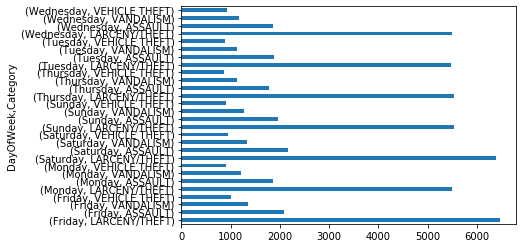

In [54]:
data_f.groupby('DayOfWeek').Category.value_counts().plot.barh()

In [61]:
tabela_ds = pd.crosstab(data_f.Category, data_f.DayOfWeek, normalize = 'index')
tabela_ds

DayOfWeek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Category,,,,,,,
ASSAULT,0.153348,0.137365,0.158872,0.144804,0.131251,0.137954,0.136407
LARCENY/THEFT,0.160286,0.136183,0.157985,0.136875,0.137049,0.135440,0.136183
VANDALISM,0.157178,0.140296,0.153918,0.148213,0.132146,0.132029,0.136221
VEHICLE THEFT,0.155632,0.140676,0.145817,0.142546,0.133354,0.137249,0.144727


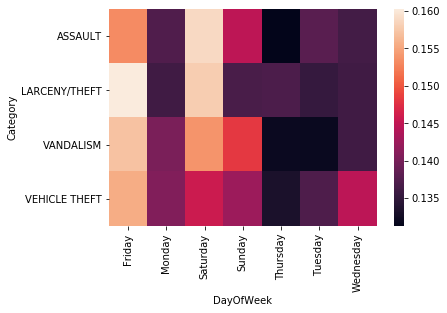

In [58]:
seaborn.heatmap(tabela, annot = False, fmt = 'd')

In [62]:
tabela_ho = pd.crosstab(data_f.Category, data_f.Time, normalize = 'index')
tabela_ho

Time,00:01,00:02,00:03,00:04,00:05,00:06,00:07,00:08,00:09,00:10,...,23:50,23:51,23:52,23:53,23:54,23:55,23:56,23:57,23:58,23:59
Category,,,,,,,,,,,,,,,,,,,,,
ASSAULT,0.015762,0.000368,0.000589,0.000074,0.001105,0.000295,0.000295,0.000884,0.000074,0.001178,...,0.001841,0.000884,0.000442,0.000147,0.000442,0.000663,0.000074,0.000074,0.000368,0.000663
LARCENY/THEFT,0.018709,0.000173,0.000124,0.000173,0.001262,0.000099,0.000025,0.000148,0.000049,0.000495,...,0.001213,0.000025,0.000049,0.000099,0.000173,0.000841,0.000000,0.000049,0.000198,0.000693
VANDALISM,0.019793,0.000349,0.000349,0.000116,0.001164,0.000116,0.000116,0.000000,0.000466,0.000815,...,0.000815,0.000349,0.000233,0.000233,0.000349,0.001048,0.000116,0.000233,0.000233,0.000699
VEHICLE THEFT,0.020876,0.000156,0.000000,0.000000,0.000779,0.000000,0.000000,0.000156,0.000156,0.000623,...,0.000935,0.000000,0.000000,0.000000,0.000000,0.000623,0.000000,0.000000,0.000000,0.002181


## Conclusão

## Fontes:
